In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

import pickle

In [2]:
transforms = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,)), transforms.Resize((8, 8))])
batch_size = 64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# MNIST dataset
train_dataset = datasets.MNIST(root='./mnist_data/',
                               train=True,
                               transform=transforms,
                               download=True)

test_dataset = datasets.MNIST(root='./mnist_data/',
                                train=False,
                                transform=transforms)

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                            batch_size=batch_size,
                                            shuffle=False)


In [4]:
# defining the model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(64, 10)
        # self.fc2 = nn.Linear(512, 256)
        # self.fc3 = nn.Linear(256, 128)
        # self.fc4 = nn.Linear(32, 10)

    def forward(self, x):
        x = x.view(-1, 64)
        x = self.fc1(x)
        # x = F.relu(self.fc2(x))
        # x = F.relu(self.fc3(x))
        # x = self.fc4(x)
        return F.log_softmax(x, dim=1)

In [5]:
'''
https://pytorch.org/docs/stable/generated/torch.addcdiv.html#torch.addcdiv

For addcdiv_ used at last

'''
class customAdam(torch.optim.Optimizer):


    def __init__(self,params,lr = 1e-3,betas = (0.99,0.999),eps = 1e-3):
        defaults = dict(lr = lr, betas = betas, eps = eps)
        super(customAdam,self).__init__(params,defaults)

    def __setstate__(self, state) -> None:
        return super(customAdam).__setstate__(state)
  
    def step(self,closure = None):
        loss = None
        if closure is not None:
            loss = closure()
        for group in self.param_groups:
            # print(self.param_groups)
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                # print(grad)
                state = self.state[p]
                # print(state)
                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p.data)
                    state['exp_avg_sq'] = torch.zeros_like(p.data)
                    beta1, beta2 = group['betas']
                    state['step'] += 1

                    state['exp_avg'] = beta1 * state['exp_avg'] + (1 - beta1) * grad
                    state['exp_avg_sq'] = beta2 * state['exp_avg_sq'] + (1 - beta2) * grad**2

                    bias_correction1 = 1 - beta1**state['step']
                    bias_correction2 = 1 - beta2**state['step']

                    p.data.addcdiv_(-group['lr'] / bias_correction1,state['exp_avg'],(state['exp_avg_sq'] / bias_correction2).sqrt() + group['eps'])

                else:
                    beta1, beta2 = group['betas']
                    state['step'] += 1
                    state['exp_avg'] = beta1 * state['exp_avg'] + (1 - beta1) * grad
                    state['exp_avg_sq'] = beta2 * state['exp_avg_sq'] + (1 - beta2) * grad**2

                    bias_correction1 = 1 - beta1**state['step']
                    bias_correction2 = 1 - beta2**state['step']

                    p.data.addcdiv_(-group['lr'] / bias_correction1,state['exp_avg'],(state['exp_avg_sq'] / bias_correction2).sqrt() + group['eps'])

        return loss


In [6]:
# training the model
criterion = nn.CrossEntropyLoss()
epochs = 10

In [7]:
# A class containing the functions for
class Trainer():
    def __init__(self, model, optimizer, lr=0.001, epochs=5):
        self.model = model

        self.lr = lr
        self.optimizer = optimizer(self.model.parameters(), lr=lr)

        self.epochs = epochs

        # defining local variables for the class
        self.train_loss = []
        self.train_acc = []
        self.val_loss = []
        self.val_acc = []


    def train(self):
        # train loop
        self.model.train()

        for epoch in range(self.epochs):
            running_loss = 0

            for batch_idx, (data, target) in enumerate(train_loader):
                data, target = data.to(device), target.to(device)
                self.optimizer.zero_grad()
                output = self.model(data)
                loss = criterion(output, target)
                loss.backward()
                self.optimizer.step()
                
                running_loss += loss.item()
                accuracy = 100*torch.sum(torch.argmax(output, dim=1) == target).item()/len(target)

                # break

            self.train_loss.append(running_loss/len(train_loader))
            self.train_acc.append(accuracy)


            self.model.eval()
            val_loss = 0
            with torch.no_grad():
                for data, target in test_loader:
                    data, target = data.to(device), target.to(device)
                    output = self.model(data)
                    val_loss += criterion(output, target).item()

                    val_acc = 100*torch.sum(torch.argmax(output, dim=1) == target).item()/len(target)

            self.val_loss.append(val_loss/len(test_loader))
            self.val_acc.append(val_acc)
            print(f"Epoch: {epoch+1}/{epochs} ::     Train Loss: {running_loss/len(train_loader)}...     Val Loss: {val_loss/len(test_loader)}")                    

        return
        

    def plot_graph(self):
        epoch_x = [i for i in range(1, self.epochs+1)]
        
        # plot loss and accuracy curves for train and validation in two separate graphs
        fig, axs = plt.subplots(1, 2, figsize=(12, 6))

        axs[0].plot(epoch_x, self.train_loss, label='Train Loss')
        axs[0].plot(epoch_x, self.val_loss, label='Val Loss')
        axs[0].set_title('Loss')
        axs[0].legend()

        axs[1].plot(epoch_x, self.train_acc, label='Train Accuracy')
        axs[1].plot(epoch_x, self.val_acc, label='Val Accuracy')
        axs[1].set_title('Accuracy')
        axs[1].legend()

        return         

In [41]:
model1 = Net().to(device)
trainer1 = Trainer(model1, optim.Adam, epochs=epochs)

In [42]:
trainer1.train()

Epoch: 1/10 ::     Train Loss: 1.0741795090469979...     Val Loss: 0.628905372539903
Epoch: 2/10 ::     Train Loss: 0.5593315875733585...     Val Loss: 0.47303046955234684
Epoch: 3/10 ::     Train Loss: 0.4623070265184333...     Val Loss: 0.41479535457814576
Epoch: 4/10 ::     Train Loss: 0.419469025835935...     Val Loss: 0.386758130731856
Epoch: 5/10 ::     Train Loss: 0.39550811109512346...     Val Loss: 0.3666765968178868
Epoch: 6/10 ::     Train Loss: 0.38102543730534977...     Val Loss: 0.3557591120813303
Epoch: 7/10 ::     Train Loss: 0.371098264940639...     Val Loss: 0.3494393740347616
Epoch: 8/10 ::     Train Loss: 0.3640808178973732...     Val Loss: 0.34300417224075763
Epoch: 9/10 ::     Train Loss: 0.3587115364097583...     Val Loss: 0.3385079487398931
Epoch: 10/10 ::     Train Loss: 0.3545865952920939...     Val Loss: 0.3367508188435796


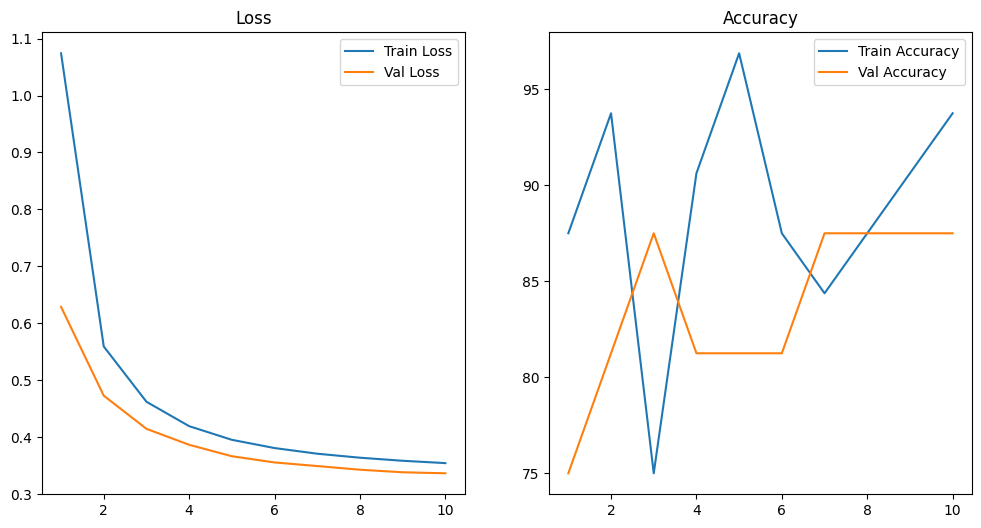

In [43]:
trainer1.plot_graph()

In [52]:
'''
https://pytorch.org/docs/stable/generated/torch.addcdiv.html#torch.addcdiv

For addcdiv_ used at last

'''
class customAdam2(torch.optim.Optimizer):


    def __init__(self,params,lr = 1e-3,betas = (0.99,0.999),eps = 1e-3):
        defaults = dict(lr = lr, betas = betas, eps = eps)
        super(customAdam2,self).__init__(params,defaults)

    def __setstate__(self, state) -> None:
        return super(customAdam2).__setstate__(state)
  
    def step(self,closure = None):
        loss = None
        if closure is not None:
            loss = closure()
        for group in self.param_groups:
            # print(self.param_groups)
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                # print(grad)
                state = self.state[p]
                # print(state)
                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p.data)
                    state['exp_avg_sq'] = torch.zeros_like(p.data)
                    beta1, beta2 = group['betas']
                    state['step'] += 1

                    state['exp_avg'] = beta1 * state['exp_avg'] + (1 - beta1) * grad
                    state['exp_avg_sq'] = beta2 * state['exp_avg_sq'] + (1 - beta2) * grad**2

                    bias_correction1 = 1 - beta1
                    bias_correction2 = 1 - beta2

                    p.data.addcdiv_(-group['lr'] / bias_correction1,state['exp_avg'],(state['exp_avg_sq'] / bias_correction2).sqrt() + group['eps'])

                else:
                    beta1, beta2 = group['betas']
                    state['step'] += 1
                    state['exp_avg'] = beta1 * state['exp_avg'] + (1 - beta1) * grad
                    state['exp_avg_sq'] = beta2 * state['exp_avg_sq'] + (1 - beta2) * grad**2

                    bias_correction1 = 1 - beta1
                    bias_correction2 = 1 - beta2

                    p.data.addcdiv_(-group['lr'] / bias_correction1,state['exp_avg'],(state['exp_avg_sq'] / bias_correction2).sqrt() + group['eps'])

        return loss


In [8]:
model2 = Net().to(device)
trainer2 = Trainer(model2, customAdam, epochs=10)

In [9]:
trainer2.train()

/tmp/ipykernel_3240/3474100789.py:43: UserWarning: This overload of addcdiv_ is deprecated:
	addcdiv_(Number value, Tensor tensor1, Tensor tensor2)
Consider using one of the following signatures instead:
	addcdiv_(Tensor tensor1, Tensor tensor2, *, Number value) (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:1630.)
  p.data.addcdiv_(-group['lr'] / bias_correction1,state['exp_avg'],(state['exp_avg_sq'] / bias_correction2).sqrt() + group['eps'])


Epoch: 1/10 ::     Train Loss: 1.0357683682873813...     Val Loss: 0.6058637782646592
Epoch: 2/10 ::     Train Loss: 0.5464401057343493...     Val Loss: 0.46742228513500494
Epoch: 3/10 ::     Train Loss: 0.45866981199555307...     Val Loss: 0.4140585574090101
Epoch: 4/10 ::     Train Loss: 0.4198023936451117...     Val Loss: 0.38550317069147805
Epoch: 5/10 ::     Train Loss: 0.39670705415610313...     Val Loss: 0.3687046684419653
Epoch: 6/10 ::     Train Loss: 0.3824367499046488...     Val Loss: 0.35761015798160983
Epoch: 7/10 ::     Train Loss: 0.3730362013284204...     Val Loss: 0.35095581426552147
Epoch: 8/10 ::     Train Loss: 0.3659616982472985...     Val Loss: 0.345257861848185
Epoch: 9/10 ::     Train Loss: 0.36113572602015315...     Val Loss: 0.34034176995372695
Epoch: 10/10 ::     Train Loss: 0.35653952284376506...     Val Loss: 0.33697895633329633


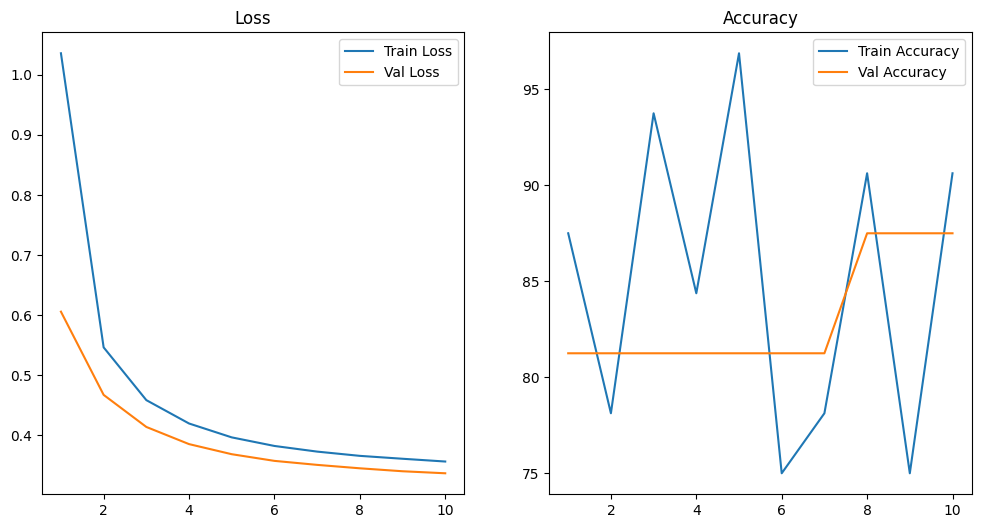

In [10]:
trainer2.plot_graph()